In [ ]:
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import optuna
from joblib import Parallel, delayed

In [2]:
def mostrar_comparacion_imagen(ruta_imagen, escala=1.0):
    # Leer la imagen con OpenCVoptimize_mean_shift("metal_dataset/test/Rolled/RS_102.bmp")
    imagen = cv2.imread(ruta_imagen, cv2.IMREAD_COLOR)
    if imagen is None:
        raise FileNotFoundError(f"No se pudo encontrar la imagen en la ruta: {ruta_imagen}")
    
    # Convertir de BGR a RGB para su correcta visualización con matplotlib
    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

    # Redimensionar la imagen según la escala proporcionada
    nueva_dim = (int(imagen_rgb.shape[1] * escala), int(imagen_rgb.shape[0] * escala))
    imagen_escalada = cv2.resize(imagen_rgb, nueva_dim)

    # Crear figura con dos subgráficos
    plt.figure(figsize=(12, 6))

    # Imagen original
    plt.subplot(1, 2, 1)
    plt.imshow(imagen_rgb)
    plt.title(f"Imagen Original{imagen.shape}")
    plt.axis('off')

    # Imagen escalada
    plt.subplot(1, 2, 2)
    plt.imshow(imagen_escalada)
    plt.title(f"Imagen Escalada x{escala}: {imagen_escalada.shape}")
    plt.axis('off')

    plt.show()

In [3]:
def mostrar_comparacion_knn(ruta_imagen, num_colores=8):
    """
    Lee una imagen desde una ruta y muestra la comparación entre la imagen original y la simplificada usando KNN.

    Parámetros:
    ruta_imagen (str): Ruta del archivo de imagen.
    num_colores (int): Número de colores para la simplificación de la imagen. Default es 8.

    Retorna:
    None
    """
    # Leer la imagen con OpenCV
    imagen = cv2.imread(ruta_imagen, cv2.IMREAD_COLOR)
    if imagen is None:
        raise FileNotFoundError(f"No se pudo encontrar la imagen en la ruta: {ruta_imagen}")
    
    # Convertir de BGR a RGB para su correcta visualización con matplotlib
    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

    # Redimensionar a un array 2D de píxeles
    pixeles = imagen_rgb.reshape(-1, 3)

    # Aplicar KMeans para encontrar los clusters de colores
    kmeans = KMeans(n_clusters=num_colores, random_state=0)
    kmeans.fit(pixeles)

    # Reemplazar los colores por los colores más cercanos (clusters)
    colores_reducidos = kmeans.cluster_centers_.astype('uint8')
    etiquetas = kmeans.labels_
    imagen_simplificada = colores_reducidos[etiquetas].reshape(imagen_rgb.shape)

    # Crear figura con dos subgráficos
    plt.figure(figsize=(12, 6))

    # Imagen original
    plt.subplot(1, 2, 1)
    plt.imshow(imagen_rgb)
    plt.title("Imagen Original")
    plt.axis('off')

    # Imagen simplificada
    plt.subplot(1, 2, 2)
    plt.imshow(imagen_simplificada)
    plt.title(f"Imagen Simplificada ({num_colores} Colores)")
    plt.axis('off')

    plt.show()

In [16]:
def optimize_mean_shift(ruta_imagen, n_tries = 20):
    def objective(trial):
        sp = trial.suggest_int('sp', 1, 60)
        sr = trial.suggest_int('sr', 1, 60)
        
        imagen = cv2.imread(ruta_imagen, cv2.IMREAD_COLOR)
        if imagen is None:
            raise FileNotFoundError(f"No se pudo encontrar la imagen en la ruta: {ruta_imagen}")

        imagen_segmentada = cv2.pyrMeanShiftFiltering(imagen, sp, sr)
        imagen_reshaped = imagen_segmentada.reshape((-1, 3))
        labels = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY).reshape(-1)

        db_score = silhouette_score(imagen_reshaped, labels)
        return db_score
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_tries, n_jobs=-1)
    return study.best_params

def mostrar_comparacion_mean_shift(ruta_imagen, sp=30, sr=60):
    """
    Lee una imagen desde una ruta y muestra la comparación entre la imagen original y la segmentada usando Mean Shift.
    Calcula métricas de calidad de agrupamiento: Davies-Bouldin, Calinski-Harabasz y Silhouette.

    Parámetros:
    ruta_imagen (str): Ruta del archivo de imagen.
    sp (int): Parámetro de radio espacial (afecta la suavidad de los bordes). Default es 30.
    sr (int): Parámetro de rango de color (afecta la agrupación de colores). Default es 60.

    Retorna:
    None
    """
    # Leer la imagen con OpenCV
    imagen = cv2.imread(ruta_imagen, cv2.IMREAD_COLOR)
    if imagen is None:
        raise FileNotFoundError(f"No se pudo encontrar la imagen en la ruta: {ruta_imagen}")

    # Convertir de BGR a RGB para su correcta visualización con matplotlib
    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

    # Aplicar el filtro Mean Shift
    imagen_segmentada = cv2.pyrMeanShiftFiltering(imagen, sp, sr)

    # Convertir la imagen procesada de BGR a RGB
    imagen_segmentada_rgb = cv2.cvtColor(imagen_segmentada, cv2.COLOR_BGR2RGB)

    # Convertir la imagen segmentada a una matriz de características
    imagen_reshaped = imagen_segmentada.reshape((-1, 3))
    labels = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY).reshape(-1)

    # Calcular métricas de agrupamiento
    db_score = davies_bouldin_score(imagen_reshaped, labels)
    ch_score = calinski_harabasz_score(imagen_reshaped, labels)
    silhouette_avg = silhouette_score(imagen_reshaped, labels)

    print(f"Davies-Bouldin Score: {db_score:.2f}")
    print(f"Calinski-Harabasz Score: {ch_score:.2f}")
    print(f"Silhouette Score: {silhouette_avg:.2f}")

    # Crear figura con dos subgráficos
    plt.figure(figsize=(12, 6))

    # Imagen original
    plt.subplot(1, 2, 1)
    plt.imshow(imagen_rgb)
    plt.title("Imagen Original")
    plt.axis('off')

    # Imagen segmentada
    plt.subplot(1, 2, 2)
    plt.imshow(imagen_segmentada_rgb)
    plt.title(f"Imagen Segmentada (sp={sp}, sr={sr})")
    plt.axis('off')

    plt.show()

In [5]:
def mostrar_comparacion_canny(ruta_imagen, umbral_min=100, umbral_max=200):
    """
    Aplica el filtro de detección de bordes Canny a una imagen en escala de grises 
    y muestra la comparación entre la imagen original y la procesada.

    Parámetros:
    ruta_imagen (str): Ruta del archivo de imagen.
    umbral_min (int): Umbral mínimo para la detección de bordes (default 100).
    umbral_max (int): Umbral máximo para la detección de bordes (default 200).

    Retorna:
    None
    """
    # Leer la imagen en escala de grises
    imagen_gray = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
    if imagen_gray is None:
        raise FileNotFoundError(f"No se pudo encontrar la imagen en la ruta: {ruta_imagen}")

    # Aplicar el filtro de detección de bordes Canny
    bordes_canny = cv2.Canny(imagen_gray, umbral_min, umbral_max)

    # Crear figura con dos subgráficos
    plt.figure(figsize=(12, 6))

    # Imagen original en escala de grises
    plt.subplot(1, 2, 1)
    plt.imshow(imagen_gray, cmap='gray')
    plt.title("Imagen Original (Blanco y Negro)")
    plt.axis('off')

    # Imagen con filtro de Canny aplicado
    plt.subplot(1, 2, 2)
    plt.imshow(bordes_canny, cmap='gray')
    plt.title(f"Detección de Bordes (Canny) \n Umbrales: {umbral_min}-{umbral_max}")
    plt.axis('off')

    plt.show()

In [ ]:
mostrar_comparacion_imagen("metal_dataset/test/Scratches/Sc_108.bmp", escala=0.5)

In [ ]:
mostrar_comparacion_knn("metal_dataset/test/Rolled/RS_102.bmp", num_colores=7)

In [17]:
optimize_mean_shift("metal_dataset/test/Rolled/RS_102.bmp", n_tries=120)

[I 2025-01-27 16:10:50,592] A new study created in memory with name: no-name-f0852876-deac-4c49-880b-8f4d95087272
[I 2025-01-27 16:10:50,715] Trial 2 finished with value: 110.04339838824818 and parameters: {'sp': 17, 'sr': 53}. Best is trial 2 with value: 110.04339838824818.
[I 2025-01-27 16:10:50,731] Trial 7 finished with value: 53.789084140436806 and parameters: {'sp': 2, 'sr': 47}. Best is trial 7 with value: 53.789084140436806.
[I 2025-01-27 16:10:50,783] Trial 1 finished with value: 88.19029424633786 and parameters: {'sp': 26, 'sr': 41}. Best is trial 7 with value: 53.789084140436806.
[I 2025-01-27 16:10:50,802] Trial 0 finished with value: 487.37115304114417 and parameters: {'sp': 29, 'sr': 57}. Best is trial 7 with value: 53.789084140436806.
[I 2025-01-27 16:10:50,871] Trial 8 finished with value: 0.299526287654062 and parameters: {'sp': 3, 'sr': 1}. Best is trial 8 with value: 0.299526287654062.
[I 2025-01-27 16:10:50,899] Trial 4 finished with value: 219.09216019722436 and pa

{'sp': 3, 'sr': 1}

Davies-Bouldin Score: 3.38
Calinski-Harabasz Score: 228817.41
Silhouette Score: 0.75


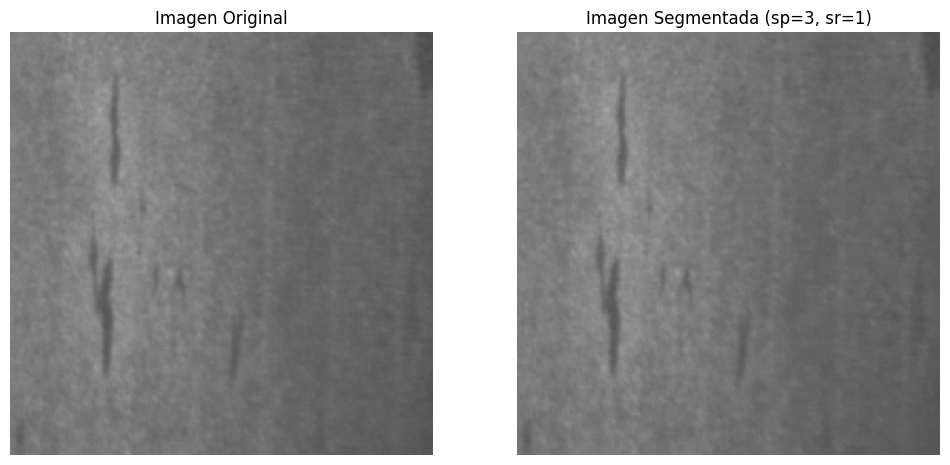

In [18]:
mostrar_comparacion_mean_shift("metal_dataset/test/Inclusion/In_107.bmp", sp=3, sr=1)

In [ ]:
mostrar_comparacion_canny("metal_dataset/test/Rolled/RS_100.bmp")